In [1]:
import json
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import cm as colormap
from scipy import stats
from scipy.stats import pearsonr, spearmanr
from collections import defaultdict, OrderedDict
from itertools import combinations
import seaborn as sns
import pandas as pd

In [28]:
with open('../analysis/data.json') as f1:
    data = json.load(f1)
    
print(data.keys())

dict_keys(['factuality-factual', 'genericity-arg-abstract', 'genericity-arg-kind', 'genericity-arg-particular', 'genericity-pred-dynamic', 'genericity-pred-hypothetical', 'genericity-pred-particular', 'time-dur-centuries', 'time-dur-days', 'time-dur-decades', 'time-dur-forever', 'time-dur-hours', 'time-dur-instant', 'time-dur-minutes', 'time-dur-months', 'time-dur-seconds', 'time-dur-weeks', 'time-dur-years', 'wordsense-supersense-noun.Tops', 'wordsense-supersense-noun.act', 'wordsense-supersense-noun.animal', 'wordsense-supersense-noun.artifact', 'wordsense-supersense-noun.attribute', 'wordsense-supersense-noun.body', 'wordsense-supersense-noun.cognition', 'wordsense-supersense-noun.communication', 'wordsense-supersense-noun.event', 'wordsense-supersense-noun.feeling', 'wordsense-supersense-noun.food', 'wordsense-supersense-noun.group', 'wordsense-supersense-noun.location', 'wordsense-supersense-noun.motive', 'wordsense-supersense-noun.object', 'wordsense-supersense-noun.person', 'wor

In [3]:
print(len(data))
print(len(data['factuality-factual']))
# print(len(data['factuality-factual']['true_val_with_node_ids']))
# print(len(data['protoroles-awareness']))
# print(data['protoroles-awareness'])

58
2


## overview
we're looking at correlation among residuals, so for each pair of properties, get the nodes that have those properties annotated. Then for each of those nodes, for each property, get the difference between true and predicted. Put that into a vector, compute correlation.

In [17]:
def compute_residuals_for_pair(p1, p2, data, diff_fxn):
    data_of_interest = {p1: data[p1],
                        p2: data[p2]}
    
    if "protoroles" in p1:
        true_key = 'true_val_with_edge_ids'
        pred_key = 'pred_val_with_edge_ids'
    else:
        true_key = 'true_val_with_node_ids'
        pred_key = 'pred_val_with_node_ids'
    
    p1_keys = data_of_interest[p1][true_key].keys()
    p2_keys = data_of_interest[p2][true_key].keys()
    intersect_keys = p1_keys & p2_keys
    residuals_p1 = []
    residuals_p2 = []
    residuals = {p1: residuals_p1,
                 p2: residuals_p2}
    
    for prop in [p1, p2]:              
        for node_key in intersect_keys:
            tv = data_of_interest[prop][true_key][node_key]
            pv = data_of_interest[prop][pred_key][node_key]
#             print(f"prop {prop} node {node_key} tv {tv} pv: {pv}" )
            diff = diff_fxn(tv, pv)
            residuals[prop].append(diff)
    residuals = {key: np.array(value) for key, value in residuals.items()}
    return residuals

ssq_err = lambda x, y: (x-y)**2
def compute_all_residuals(data, function=spearmanr, diff_fxn=ssq_err):
    all_pairs = combinations(data.keys(), 2)
    all_pairs = [(p1, p2) for p1, p2 in all_pairs if p1 != p2]
    all_residuals = []
    all_correlations = {}
    for p1, p2 in all_pairs:
        residuals = compute_residuals_for_pair(p1, p2, data, diff_fxn)
        if len(residuals[p1]) > 2:
            rho, p = function(residuals[p1], residuals[p2])
            correlation = (rho, p)
        else:
            correlation = np.nan
        all_correlations[(p1,p2)] = correlation
        all_correlations[(p2,p1)] = correlation
        all_residuals.append(residuals)
#         if p1 == "factuality-factual":
#             print(f"factuality and {p2} {correlation}")
#     print([key for key, value in all_correlations.items() if type(value) == tuple])
    return all_correlations

all_correlations_pearson_squared = compute_all_residuals(data, function = pearsonr)
all_correlations_spearman_squared = compute_all_residuals(data, function = spearmanr)
all_correlations_pearson_total = compute_all_residuals(data, function = pearsonr, 
                                                           diff_fxn = lambda x, y: x-y)
all_correlations_spearman_total = compute_all_residuals(data, function = spearmanr, 
                                                            diff_fxn = lambda x, y: x-y)


In [97]:
show_names = {'genericity-arg-abstract': "gen-abstract", 
              'genericity-arg-kind': "gen-kind", 
              'genericity-arg-particular': "gen-particular",  
              'wordsense-supersense-noun.person': "ws-person",
             'wordsense-supersense-noun.artifact': "ws-artifact",  
              'wordsense-supersense-noun.communication': "ws-comm.",
             'wordsense-supersense-noun.event': "ws-event",  
              'wordsense-supersense-noun.state': "ws-state",
             'wordsense-supersense-noun.object': "ws-object",  
              'wordsense-supersense-noun.cognition': "ws-cognition",
              'wordsense-supersense-noun.plant': "ws-plant",
              'wordsense-supersense-noun.animal': "ws-animal",
             'factuality-factual': "factuality", 
              'genericity-pred-dynamic': "gen-dynamic", 
              'genericity-pred-hypothetical': "gen-hypo.",
              'genericity-pred-particular': "gen-particular", 
              'time-dur-centuries': "dur-centuries", 
              'time-dur-days': 'dur-days',
              'time-dur-decades':'dur-decades', 
              'time-dur-forever': 'dur-forever', 
              'time-dur-hours': 'dur-hours', 
              'time-dur-instant': 'dur-instant',
              'time-dur-minutes': 'dur-minutes', 
              'time-dur-months': 'dur-months', 
              'time-dur-seconds': 'dur-seconds', 
              'time-dur-weeks': 'dur-weeks',
              'time-dur-years': 'dur-years', 
              'protoroles-awareness': 'awareness',
              'protoroles-change_of_location': 'chng_loc.', 
              'protoroles-change_of_possession': 'chng_poss.', 
              'protoroles-change_of_state': 'chng_of_state',
              'protoroles-change_of_state_continuous': 'chng_state_cont.', 
              'protoroles-existed_after': 'existed_after', 
              'protoroles-existed_before': 'existed_before',
              'protoroles-existed_during': 'existed_during',
              'protoroles-instigation': 'instigation', 
              'protoroles-partitive':'partitive', 
              'protoroles-sentient':'sentient',
              'protoroles-volition': 'volition', 
              'protoroles-was_for_benefit': 'was_for_benefit', 
              'protoroles-was_used': 'was_used'} 


In [98]:
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
from mpl_toolkits.axes_grid1.colorbar import colorbar

def heatmap(all_correlations, keys, show_scale = True):
    indices = {key: i for i, key in enumerate(keys)}
    to_plot = np.zeros((len(keys), len(keys) ))
#     df_dict = OrderedDict()
#     for (p1, p2) in sorted(list(all_correlations.keys())):
    for p1, p2 in  all_correlations.keys():
#             print(p1, p2)
        if p1 not in keys or p2 not in keys:
            continue 
#         if (p1, p2) not in all_correlations.keys():
#             r_score = np.nan
#             p_value = 1.0
        else:
            try:
                (r_score, p_value) = all_correlations[(p1, p2)]
#                 print(r_score)
    #             df_dict[p1][p2] = r_score
            except TypeError:
                r_score = np.nan
                p_value = 1.0

        # BONFERRONI CORRECTION
        thresh = 0.05 / len(keys)
        if p_value < thresh and not np.isnan(r_score):
            to_plot[indices[p1], indices[p2]] = r_score
            
#     print(to_plot.shape)
    dataframe = pd.DataFrame(to_plot) 
    dataframe = dataframe.fillna(-100)
    print_keys = [show_names[k] for k in keys]
    dataframe.rename( index = {i:k for i, k in enumerate(print_keys)}, 
                     inplace=True)
    dataframe.rename(columns = {i:k for i, k in enumerate(print_keys)}, inplace=True)

#     print(dataframe['time-dur-centuries'])
    plt.tight_layout()
    all_vals = [x[0] for x in all_correlations.values() if type(x) == tuple and len(x) == 2 and x[1] < 0.05 ] 
    min_val, max_val = min(all_vals), max(all_vals)
    top = max(abs(min_val), abs(max_val))
    
    vmin = -top
    vmax = top
    
    cmap = sns.diverging_palette(10, 271, s=74, l=44, sep=1, n=2048)
    
    if show_scale: 
        cg = sns.clustermap(dataframe, vmin=vmin, vmax=vmax, cmap = cmap)
#         cbar = cg.ax_heatmap.collections[0].colorbar
        ax_divider = make_axes_locatable(cg.ax_heatmap)
        cax = ax_divider.append_axes('top', size = '5%', pad = '2%')
        colorbar(cg.ax_heatmap.get_children()[0], cax = cax, orientation = 'horizontal')
    
        # locate colorbar ticks
        cax.xaxis.set_ticks_position('top')
#         cax[0].outline.set_visible(False)
#         cbar.ax.tick_params(labelsize=10)
        cax.set_frame_on(False)
        cg.cax.set_visible(False)
    
    else:
        cg = sns.clustermap(dataframe, vmin=vmin, vmax=vmax, cmap = cmap)
        cg.cax.set_visible(False)

    cg.ax_row_dendrogram.set_visible(False)
    cg.ax_col_dendrogram.set_visible(False)
#     cg.xticks(rotation=45)
    plt.setp(cg.ax_heatmap.xaxis.get_majorticklabels(), rotation=45, horizontalalignment='right')
    return cg
    

/Users/Elias/miniconda3/envs/miso/lib/python3.7/site-packages/seaborn/matrix.py:603: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  metric=self.metric)
/Users/Elias/miniconda3/envs/miso/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

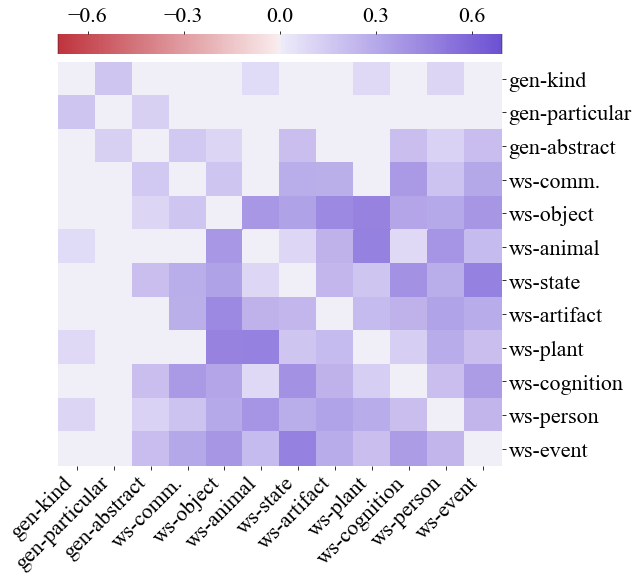

<Figure size 432x288 with 0 Axes>

In [105]:
import matplotlib
font = {'family' : 'Times New Roman',
        'weight' : 'normal',
        'size'   : 22}

matplotlib.rc('font', **font)


# person, artifact, communication, event, state, object, and cognition
arg_node_keys = [ 'genericity-arg-abstract', 'genericity-arg-kind', 
              'genericity-arg-particular',  'wordsense-supersense-noun.person',
             'wordsense-supersense-noun.artifact',  'wordsense-supersense-noun.communication',
             'wordsense-supersense-noun.event',  'wordsense-supersense-noun.state',
             'wordsense-supersense-noun.object',  'wordsense-supersense-noun.cognition',
                 'wordsense-supersense-noun.plant', 'wordsense-supersense-noun.animal']

# node_cg = heatmap(all_correlations_pearson, arg_node_keys)
# plt.tight_layout()
# node_cg.savefig("/Users/Elias/decomp-acl-2020/figures/node_arg_cluster_pearson.pdf")

# plt.figure()

node_cg = heatmap(all_correlations_spearman_squared, arg_node_keys)
plt.tight_layout()
node_cg.savefig("/Users/Elias/decomp-acl-2020/figures/node_arg_cluster_spearman_squared.pdf")

plt.figure()

# node_cg = heatmap(all_correlations_spearman_total, arg_node_keys)
# plt.tight_layout()
# node_cg.savefig("/Users/Elias/decomp-acl-2020/figures/node_arg_cluster_spearman_total.pdf")

# plt.figure()




/Users/Elias/miniconda3/envs/miso/lib/python3.7/site-packages/ipykernel_launcher.py:21: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

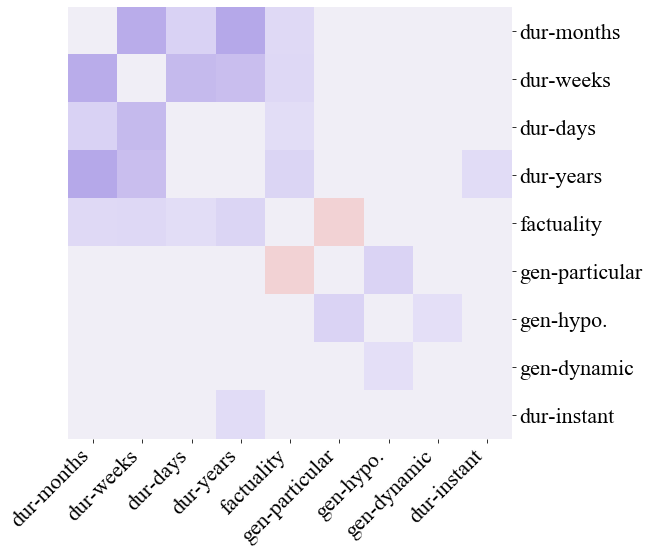

<Figure size 432x288 with 0 Axes>

In [106]:
# pred_node_keys =  ['factuality-factual', 'genericity-pred-dynamic', 'genericity-pred-hypothetical',
#               'genericity-pred-particular', 'time-dur-centuries', 'time-dur-days',
#               'time-dur-decades', 'time-dur-forever', 'time-dur-hours', 'time-dur-instant',
#               'time-dur-minutes', 'time-dur-months', 'time-dur-seconds', 'time-dur-weeks', 
#               'time-dur-years']

pred_node_keys =  ['factuality-factual', 'genericity-pred-dynamic', 'genericity-pred-hypothetical',
              'genericity-pred-particular',  'time-dur-days',
                'time-dur-instant',
               'time-dur-months',  'time-dur-weeks', 
              'time-dur-years']


# node_cg = heatmap(all_correlations_pearson, pred_node_keys, show_scale = False)
# plt.tight_layout()
# node_cg.savefig("/Users/Elias/decomp-acl-2020/figures/node_pred_cluster_pearson.pdf")

# plt.figure()

node_cg = heatmap(all_correlations_spearman_squared, pred_node_keys, show_scale = False)
plt.tight_layout()
node_cg.savefig("/Users/Elias/decomp-acl-2020/figures/node_pred_cluster_spearman_squared.pdf")

plt.figure()

# node_cg = heatmap(all_correlations_spearman_total, pred_node_keys, show_scale = False)
# plt.tight_layout()
# node_cg.savefig("/Users/Elias/decomp-acl-2020/figures/node_pred_cluster_spearman_total.pdf")

# plt.figure()

/Users/Elias/miniconda3/envs/miso/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  # Remove the CWD from sys.path while we load stuff.


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

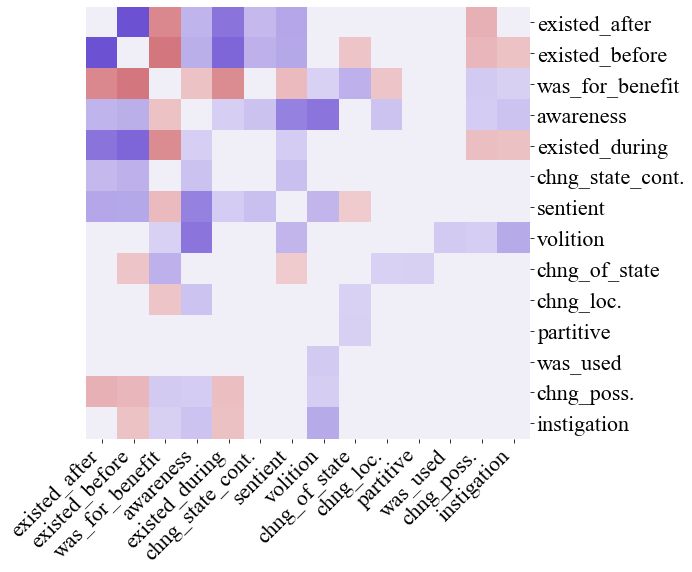

<Figure size 432x288 with 0 Axes>

In [107]:
edge_keys = ['protoroles-awareness', 'protoroles-change_of_location', 'protoroles-change_of_possession', 'protoroles-change_of_state', 'protoroles-change_of_state_continuous', 'protoroles-existed_after', 'protoroles-existed_before', 'protoroles-existed_during', 'protoroles-instigation', 'protoroles-partitive', 'protoroles-sentient', 'protoroles-volition', 'protoroles-was_for_benefit', 'protoroles-was_used']

# edge_cg = heatmap(all_correlations_pearson, edge_keys, show_scale=False)
# plt.tight_layout()
# edge_cg.savefig("/Users/Elias/decomp-acl-2020/figures/edge_cluster_pearson.pdf")

# plt.figure()

edge_cg = heatmap(all_correlations_spearman_squared, edge_keys, show_scale=False)
plt.tight_layout()
edge_cg.savefig("/Users/Elias/decomp-acl-2020/figures/edge_cluster_spearman_squared.pdf")

plt.figure()

# edge_cg = heatmap(all_correlations_spearman_total, edge_keys, show_scale=False)
# plt.tight_layout()
# edge_cg.savefig("/Users/Elias/decomp-acl-2020/figures/edge_cluster_spearman_total.pdf")

# plt.figure()


